# Group by Time Effects

Kendra Wyant  
January 27, 2025

### Set Up Environment

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

In [ ]:

suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(tidymodels))
suppressPackageStartupMessages(library(tidyposterior))
library(kableExtra, exclude = "group_rows")
library(Rcpp, exclude = "populate")
library(brms, exclude = c("ar", "mixture"))


Loading 'brms' package (version 2.22.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').

In [ ]:

devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true")


ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

ℹ SHA-1 hash of file is "6e9288d22f09da9ec15a1d5c046a0b6736ecce8b"

In [ ]:
path_processed <- format_path(str_c("studydata/risk/data_processed/lag"))
path_models_lag <- format_path(str_c("studydata/risk/models/lag"))


### Read in Model Performance Metrics

In [ ]:
auroc_dem_0 <- read_csv(here::here(path_models_lag, 
                                   "test_auroc_6_x_5_1day_0_v3_nested_dem.csv"),
                      col_types = cols()) |> 
  mutate(fold_num = rep(1:5, 6),
         repeat_num = c(rep(1, 5), rep(2, 5), rep(3, 5), 
                        rep(4, 5), rep(5, 5), rep(6, 5))) |> 
  mutate(across(everything(), ~if_else(.x == 0, .0000001, .x))) |> 
  select(-outer_split_num)


auroc_dem_24 <- read_csv(here::here(path_models_lag, 
                                    "test_auroc_6_x_5_1day_24_v3_nested_dem.csv"),
                      col_types = cols())  |> 
  mutate(across(everything(), ~if_else(.x == 0, .0000001, .x))) |> 
  mutate(fold_num = rep(1:5, 6),
         repeat_num = c(rep(1, 5), rep(2, 5), rep(3, 5), 
                        rep(4, 5), rep(5, 5), rep(6, 5))) |> 
  select(-outer_split_num)

auroc_dem_72 <- read_csv(here::here(path_models_lag, 
                                    "test_auroc_6_x_5_1day_72_v3_nested_dem.csv"),
                      col_types = cols()) |> 
  mutate(across(everything(), ~if_else(.x == 0, .0000001, .x))) |> 
  mutate(fold_num = rep(1:5, 6),
         repeat_num = c(rep(1, 5), rep(2, 5), rep(3, 5), 
                        rep(4, 5), rep(5, 5), rep(6, 5))) |> 
  select(-outer_split_num)

auroc_dem_168 <- read_csv(here::here(path_models_lag, 
                                     "test_auroc_6_x_5_1day_168_v3_nested_dem.csv"),
                      col_types = cols())  |> 
  mutate(across(everything(), ~if_else(.x == 0, .0000001, .x))) |> 
  mutate(fold_num = rep(1:5, 6),
         repeat_num = c(rep(1, 5), rep(2, 5), rep(3, 5), 
                        rep(4, 5), rep(5, 5), rep(6, 5))) |> 
  select(-outer_split_num)

auroc_dem_336 <- read_csv(here::here(path_models_lag, 
                                     "test_auroc_6_x_5_1day_336_v3_nested_dem.csv"),
                      col_types = cols())  |> 
  add_row(outer_split_num = 12) |>
  add_row(outer_split_num = 28) |>
  arrange(outer_split_num) |>
  mutate(across(everything(), ~if_else(.x == 0, .0000001, .x))) |> 
  mutate(fold_num = rep(1:5, 6),
         repeat_num = c(rep(1, 5), rep(2, 5), rep(3, 5), 
                        rep(4, 5), rep(5, 5), rep(6, 5))) |> 
  select(-outer_split_num)


In [ ]:
auroc_dem_all <- auroc_dem_0 |> 
  mutate(lag = 0) |> 
  bind_rows(auroc_dem_24 |> 
              mutate(lag = 24)) |>
  bind_rows(auroc_dem_72 |> 
              mutate(lag = 72)) |>
  bind_rows(auroc_dem_168 |> 
              mutate(lag = 168)) |>
  bind_rows(auroc_dem_336 |> 
              mutate(lag = 336))

set.seed(101)


### Race

In [ ]:
data <- auroc_dem_all |> 
  select(id = fold_num, id2 = repeat_num, `not white`, `non-hispanic white` = white, lag) |> 
  pivot_longer(cols = c(`not white`, `non-hispanic white`), names_to = "race", values_to = "auroc") |> 
  mutate(race = factor(race)) |>
  glimpse()


Rows: 300
Columns: 5
$ id    <dbl> 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 1, 1…
$ id2   <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3…
$ lag   <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ race  <fct> not white, non-hispanic white, not white, non-hispanic white, no…
$ auroc <dbl> 0.9540139, 0.8926833, 0.3760259, 0.9203346, 0.7861969, 0.8664982…

Set priors to `perf_mod()` defaults

In [ ]:
priors <- c(
  prior(normal(2, 1.1), class = "Intercept"),
  
  prior(normal(0, 2.79), class = "b"),

  prior(exponential(2.2), class = "sigma")
)


In [ ]:
model_race <- brm(
  formula = auroc ~ 1 + race + lag + race*lag + (1 | id2/id), # folds nested in repeats
  data = subset(data, !is.na(auroc)),
  family = gaussian(link = "logit"), # normal distribution w/auroc bounded between 0 and 1
  chains = 4,
  prior = priors,
  control = list(adapt_delta = 0.99), 
  iter = 6000,
  thin = 10,
  seed = 123
)


Compiling Stan program...

Start sampling


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000119 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.19 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 6000 [  0%]  (Warmup)
Chain 1: Iteration:  600 / 6000 [ 10%]  (Warmup)
Chain 1: Iteration: 1200 / 6000 [ 20%]  (Warmup)
Chain 1: Iteration: 1800 / 6000 [ 30%]  (Warmup)
Chain 1: Iteration: 2400 / 6000 [ 40%]  (Warmup)
Chain 1: Iteration: 3000 / 6000 [ 50%]  (Warmup)
Chain 1: Iteration: 3001 / 6000 [ 50%]  (Sampling)
Chain 1: Iteration: 3600 / 6000 [ 60%]  (Sampling)
Chain 1: Iteration: 4200 / 6000 [ 70%]  (Sampling)
Chain 1: Iteration: 4800 / 6000 [ 80%]  (Sampling)
Chain 1: Iteration: 5400 / 6000 [ 90%]  (Sampling)
Chain 1: Iteration: 6000 / 6000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 28.981 seconds (Warm-up)
Chain 1:                19.363 seconds (Sampling)
Chain 1:                4

In [ ]:
summary(model_race) 


 Family: gaussian 
  Links: mu = logit; sigma = identity 
Formula: auroc ~ 1 + race + lag + race * lag + (1 | id2/id) 
   Data: subset(data, !is.na(auroc)) (Number of observations: 280) 
  Draws: 4 chains, each with iter = 6000; warmup = 3000; thin = 10;
         total post-warmup draws = 1200

Multilevel Hyperparameters:
~id2 (Number of levels: 6) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.22      0.20     0.01     0.76 1.00     1099     1059

~id2:id (Number of levels: 30) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.88      0.14     0.65     1.19 1.00     1143     1143

Regression Coefficients:
                 Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept            3.19      0.29     2.64     3.80 1.00     1190     1061
racenotwhite        -2.18      0.22    -2.62    -1.79 1.00     1203     1200
lag                 -0.00      0.00    -0.00    -0.00 1.00    

In [ ]:
pp_race <- summary(model_race)$fixed |>
  as_tibble(rownames = "coef") |> 
  select(coef,
         pp_mean = Estimate, 
         pp_lower = `l-95% CI`, 
         pp_upper = `u-95% CI`) 


plot posterior distribution for race effect

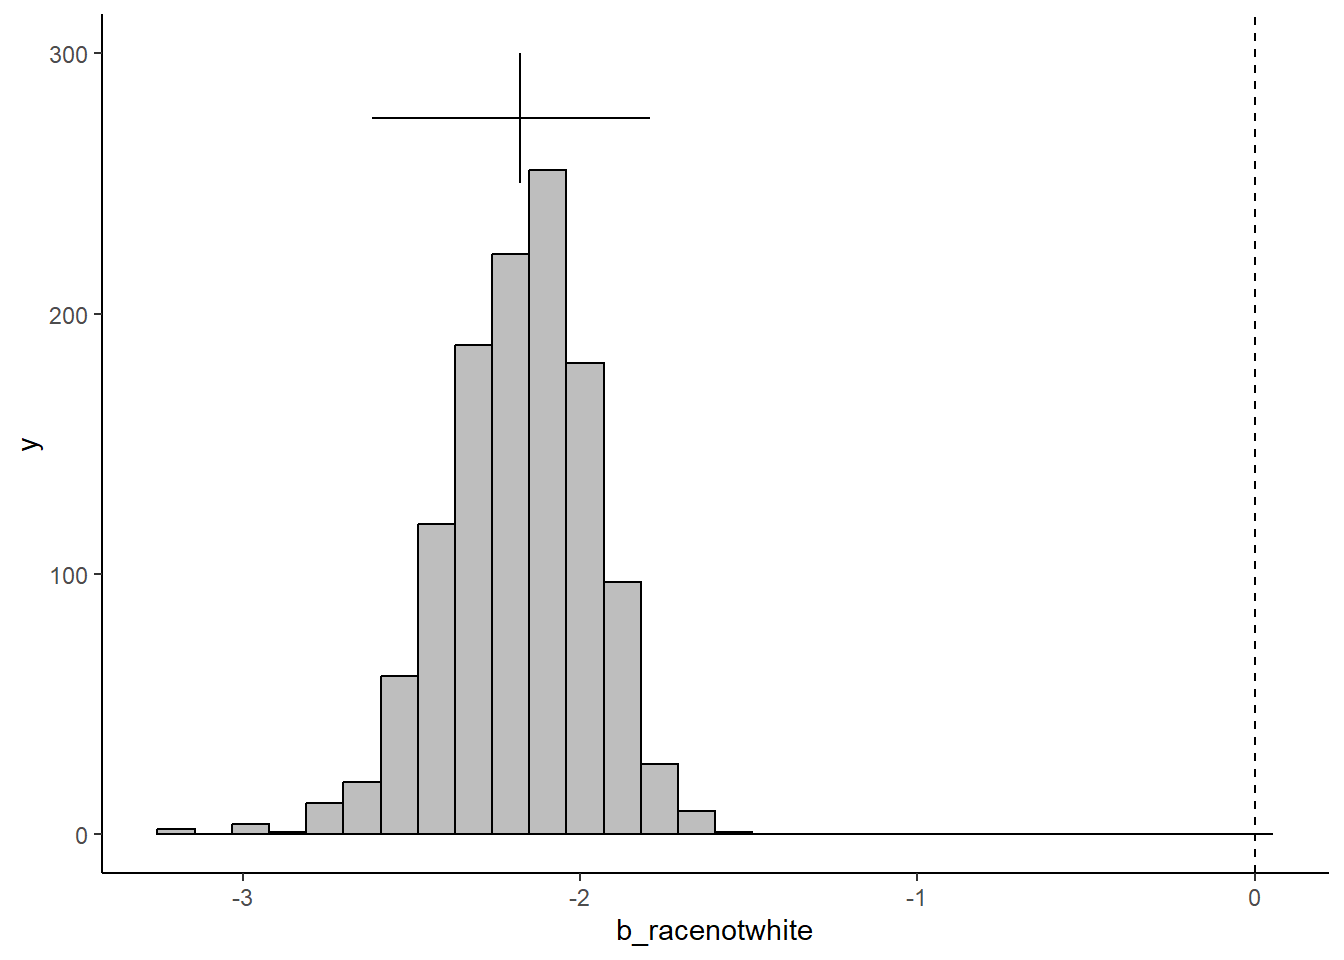

In [ ]:
as.matrix(model_race, variable = "b_racenotwhite") |> 
  as_tibble() |> 
  ggplot(aes(x = b_racenotwhite)) +
  geom_histogram(fill = "grey", color = "black", bins = 30) +
  geom_segment(mapping = aes(y = 250, yend = 300, x = pp_mean, xend = pp_mean),
               data = subset(pp_race, coef == "racenotwhite")) +
  geom_segment(mapping = aes(y = 275, yend = 275, x = pp_lower, xend = pp_upper),
                data = subset(pp_race, coef == "racenotwhite")) +
  geom_vline(xintercept = 0, linetype =  "dashed") 


plot posterior distribution for interaction effect

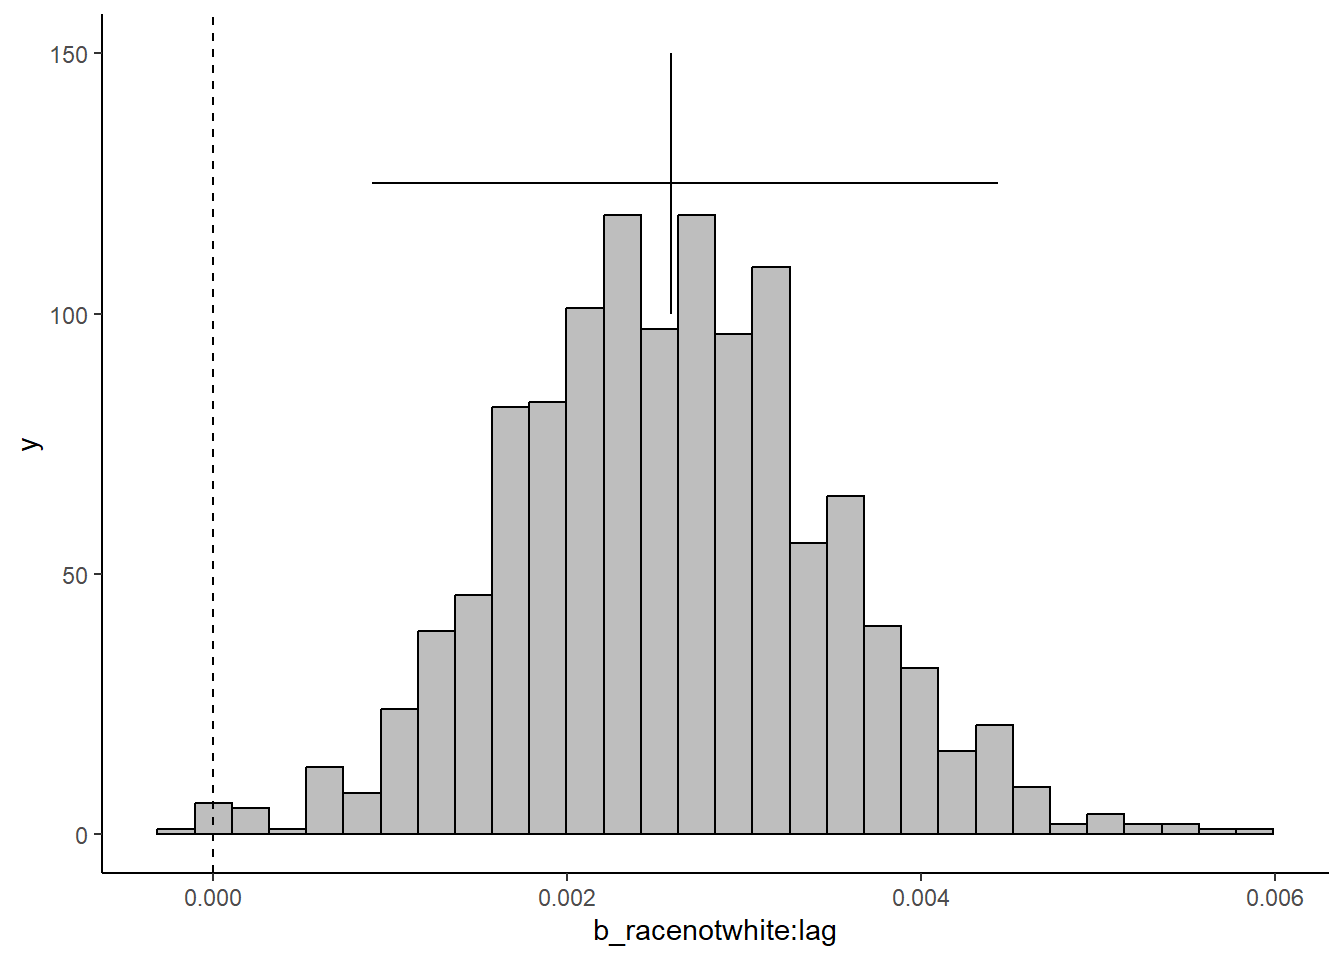

In [ ]:
as.matrix(model_race, variable = "b_racenotwhite:lag") |> 
  ggplot(aes(x = `b_racenotwhite:lag`)) +
  geom_histogram(fill = "grey", color = "black", bins = 30) +
    geom_segment(mapping = aes(y = 100, yend = 150, x = pp_mean, xend = pp_mean),
               data = subset(pp_race, coef == "racenotwhite:lag")) +
  geom_segment(mapping = aes(y = 125, yend = 125, x = pp_lower, xend = pp_upper),
                data = subset(pp_race, coef == "racenotwhite:lag")) +
  geom_vline(xintercept = 0, linetype =  "dashed") 


Check convergence diagnostics

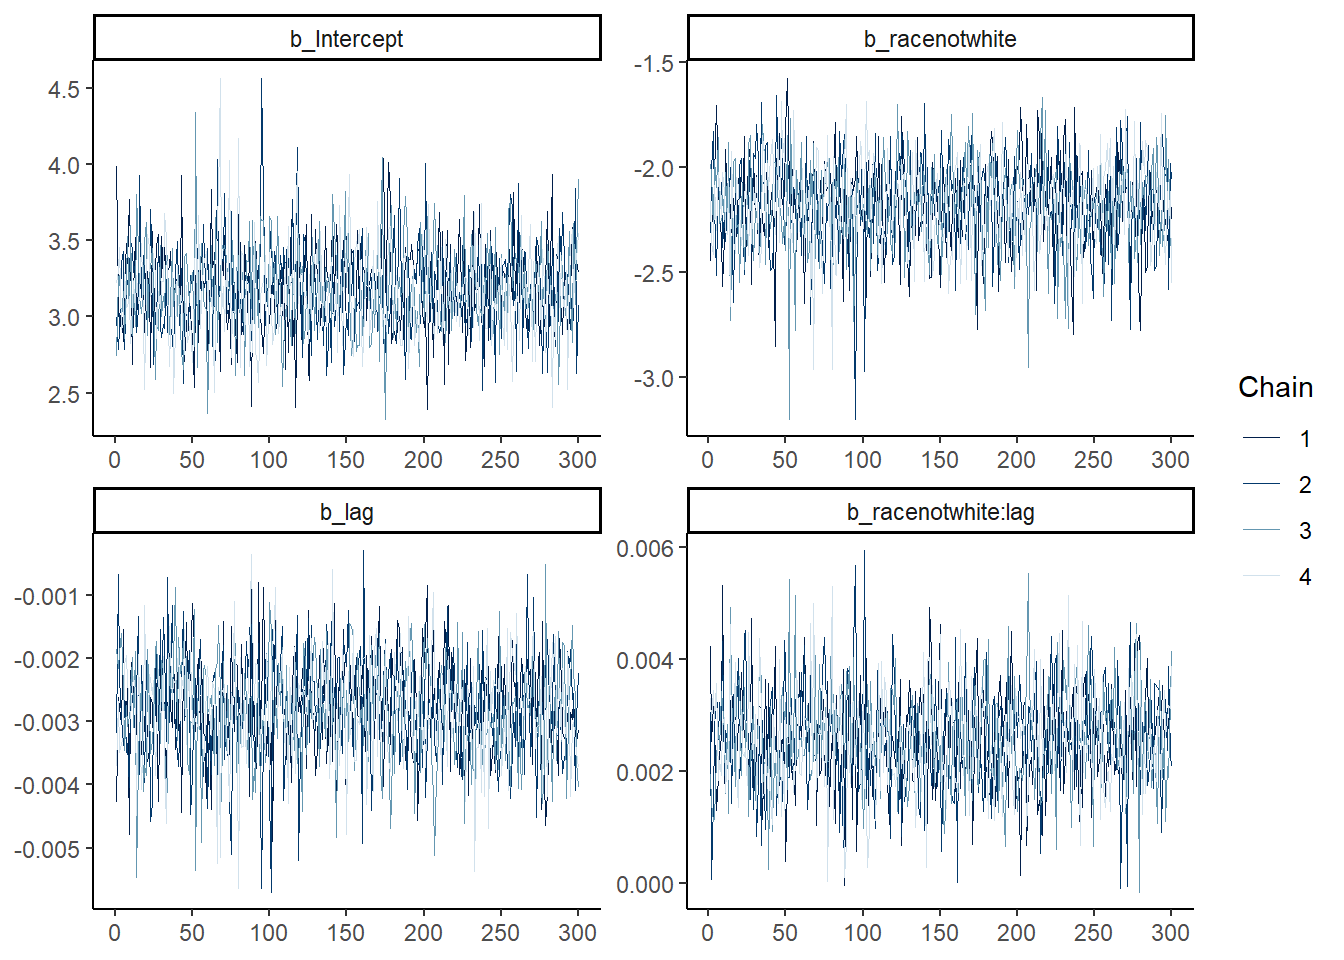

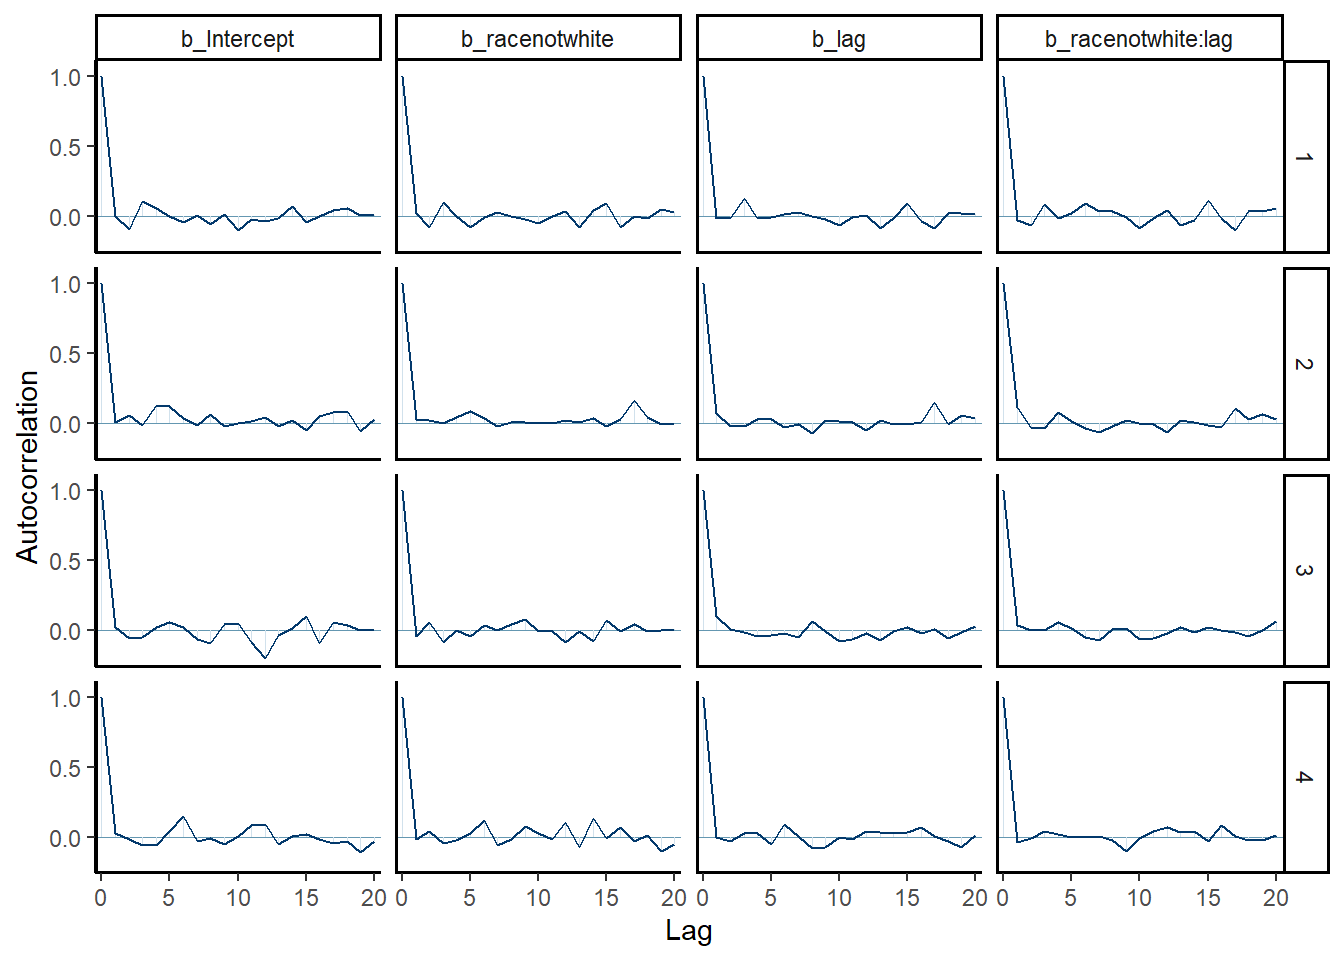

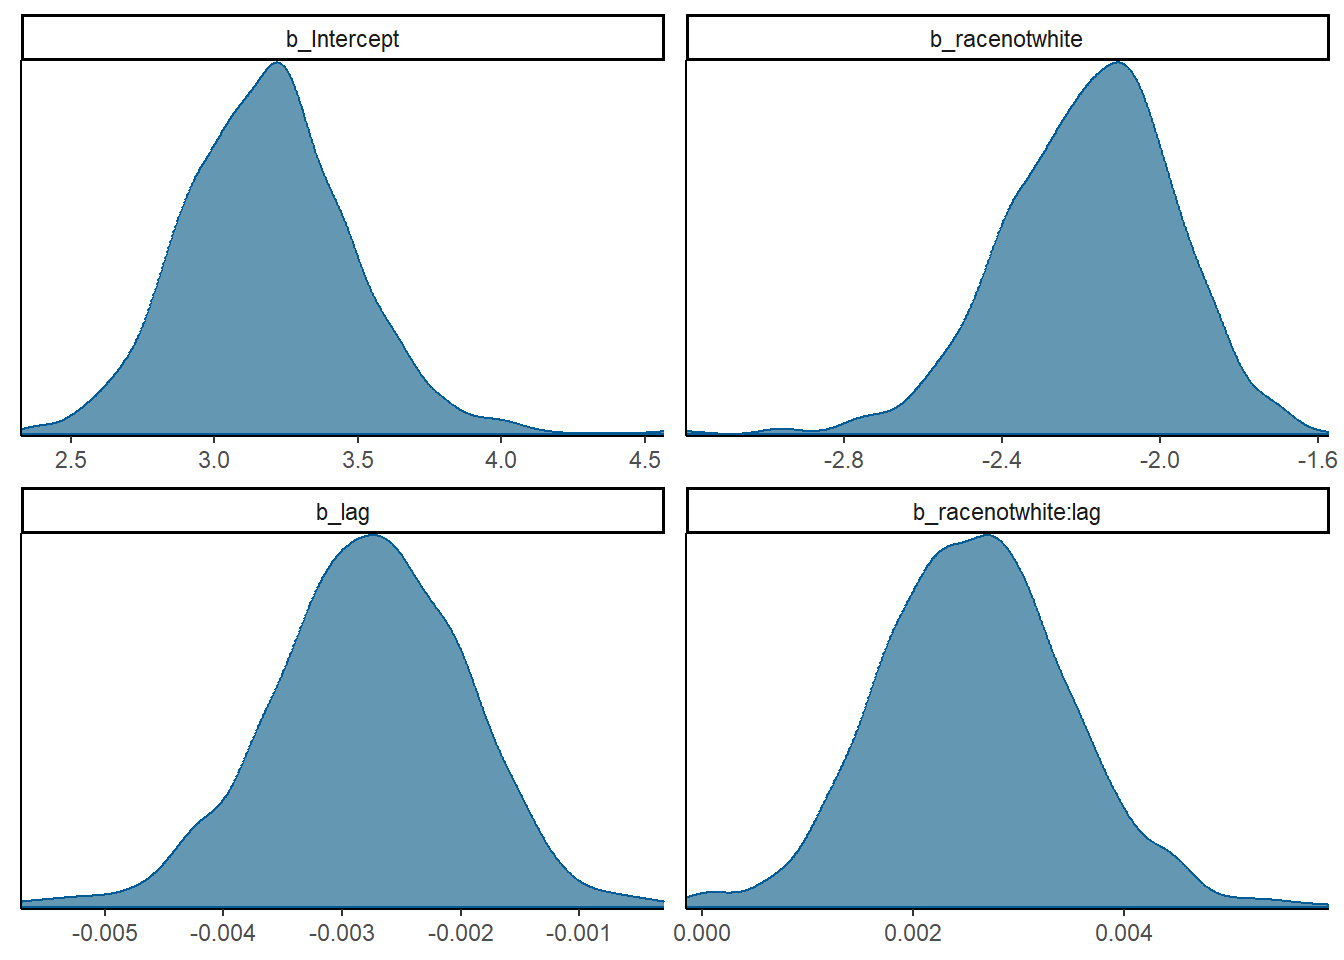

In [ ]:
bayesplot::mcmc_trace(model_race, pars = c("b_Intercept", "b_racenotwhite", "b_lag", "b_racenotwhite:lag"))


Check posteriors

Using 10 posterior draws for ppc type 'dens_overlay' by default.

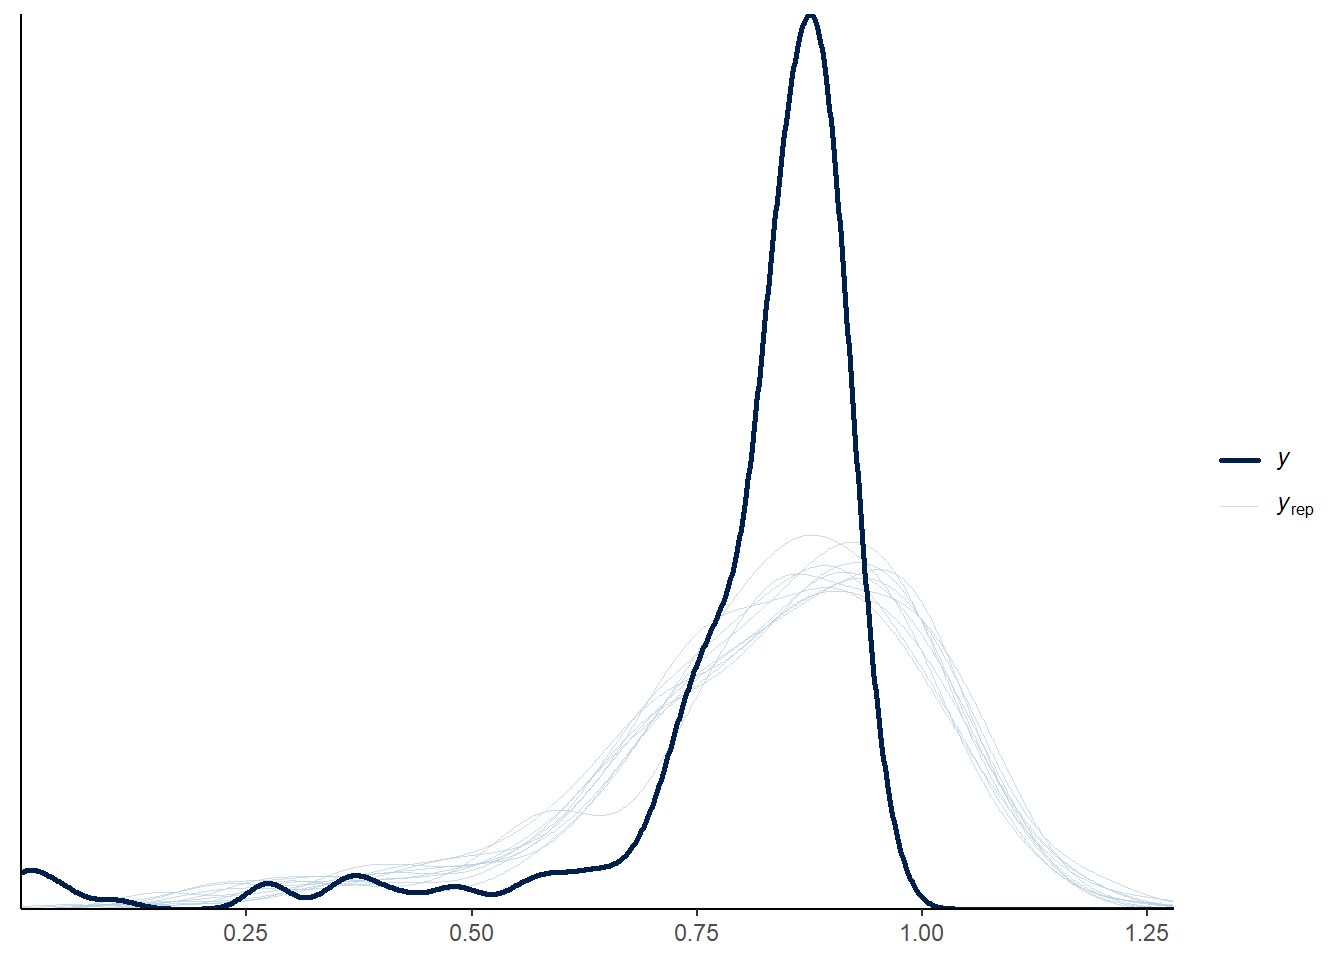

In [ ]:
pp_check(model_race)


### Sex

In [ ]:
data <- auroc_dem_all |> 
  select(id = fold_num, id2 = repeat_num, female, male, lag) |> 
  pivot_longer(cols = c(female, male), names_to = "sex", values_to = "auroc") |>
  mutate(sex = factor(sex, levels = c("male", "female"))) |>
  glimpse()


Rows: 300
Columns: 5
$ id    <dbl> 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 1, 1…
$ id2   <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3…
$ lag   <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ sex   <fct> female, male, female, male, female, male, female, male, female, …
$ auroc <dbl> 0.8533697, 0.9353514, 0.8004071, 0.9713206, 0.8541759, 0.8814394…

Compiling Stan program...

Start sampling


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.98 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 6000 [  0%]  (Warmup)
Chain 1: Iteration:  600 / 6000 [ 10%]  (Warmup)
Chain 1: Iteration: 1200 / 6000 [ 20%]  (Warmup)
Chain 1: Iteration: 1800 / 6000 [ 30%]  (Warmup)
Chain 1: Iteration: 2400 / 6000 [ 40%]  (Warmup)
Chain 1: Iteration: 3000 / 6000 [ 50%]  (Warmup)
Chain 1: Iteration: 3001 / 6000 [ 50%]  (Sampling)
Chain 1: Iteration: 3600 / 6000 [ 60%]  (Sampling)
Chain 1: Iteration: 4200 / 6000 [ 70%]  (Sampling)
Chain 1: Iteration: 4800 / 6000 [ 80%]  (Sampling)
Chain 1: Iteration: 5400 / 6000 [ 90%]  (Sampling)
Chain 1: Iteration: 6000 / 6000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 52.927 seconds (Warm-up)
Chain 1:                23.973 seconds (Sampling)
Chain 1:                76

In [ ]:
summary(model_sex)


 Family: gaussian 
  Links: mu = logit; sigma = identity 
Formula: auroc ~ 1 + sex + lag + sex * lag + (1 | id2/id) 
   Data: subset(data, !is.na(auroc)) (Number of observations: 296) 
  Draws: 4 chains, each with iter = 6000; warmup = 3000; thin = 10;
         total post-warmup draws = 1200

Multilevel Hyperparameters:
~id2 (Number of levels: 6) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.07      0.07     0.00     0.24 1.00      997     1122

~id2:id (Number of levels: 30) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.26      0.04     0.19     0.35 1.00     1098     1258

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         2.29      0.08     2.14     2.44 1.00     1092     1097
sexfemale        -0.48      0.05    -0.58    -0.37 1.00     1284     1211
lag              -0.00      0.00    -0.00    -0.00 1.00     1228     1087

In [ ]:
pp_sex <- summary(model_sex)$fixed |>
  as_tibble(rownames = "coef") |> 
  select(coef,
         pp_mean = Estimate, 
         pp_lower = `l-95% CI`, 
         pp_upper = `u-95% CI`) 


plot posterior distribution for sex effect

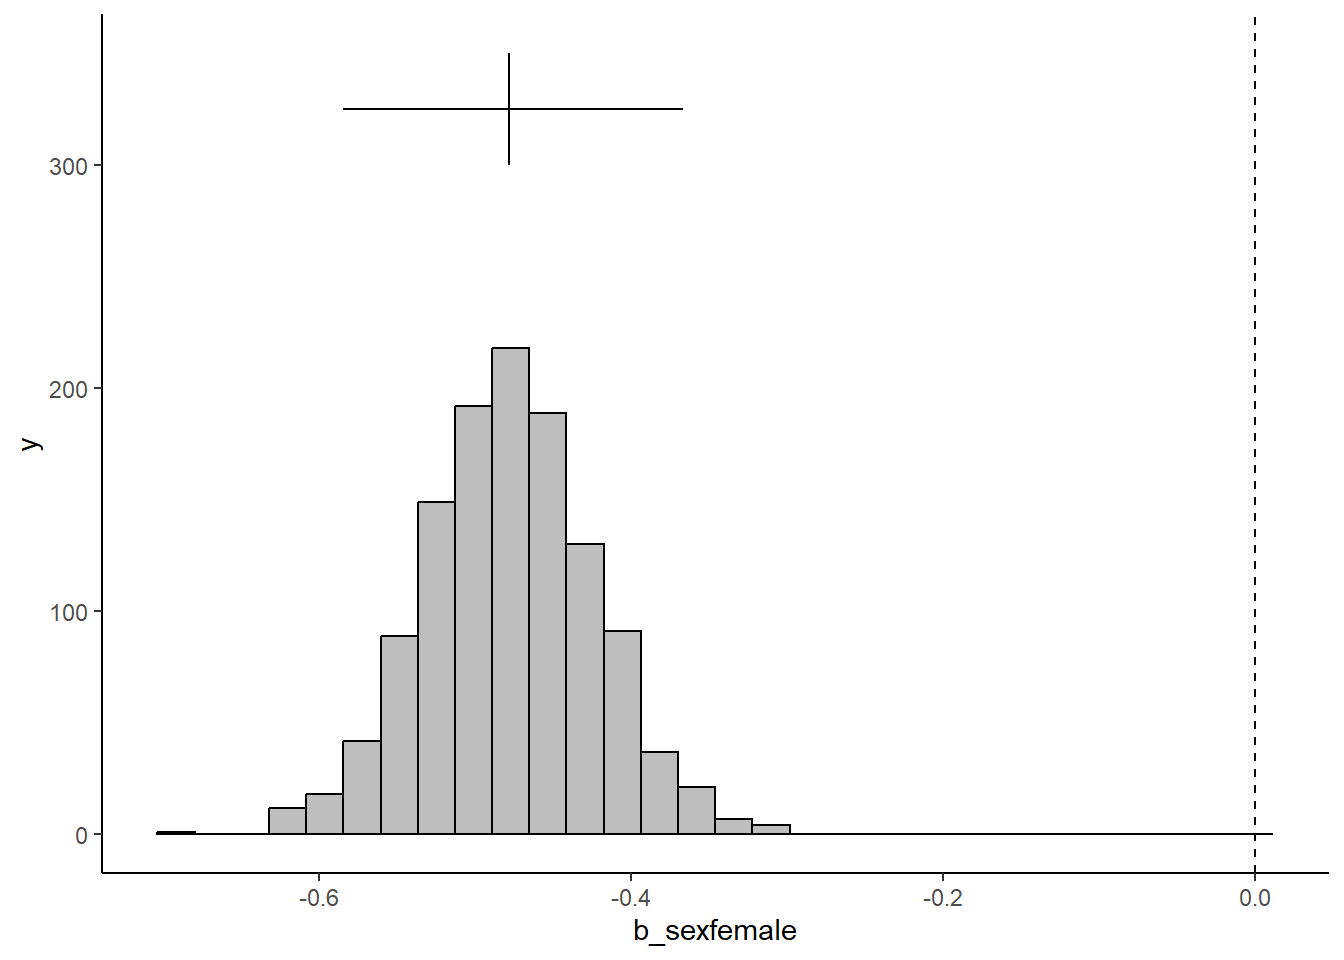

In [ ]:
as.matrix(model_sex, variable = "b_sexfemale") |> 
  as_tibble() |> 
  ggplot(aes(x = b_sexfemale)) +
  geom_histogram(fill = "grey", color = "black", bins = 30) +
  geom_segment(mapping = aes(y = 300, yend = 350, x = pp_mean, xend = pp_mean),
               data = subset(pp_sex, coef == "sexfemale")) +
  geom_segment(mapping = aes(y = 325, yend = 325, x = pp_lower, xend = pp_upper),
                data = subset(pp_sex, coef == "sexfemale")) +
  geom_vline(xintercept = 0, linetype =  "dashed") 


plot posterior distribution for interaction effect

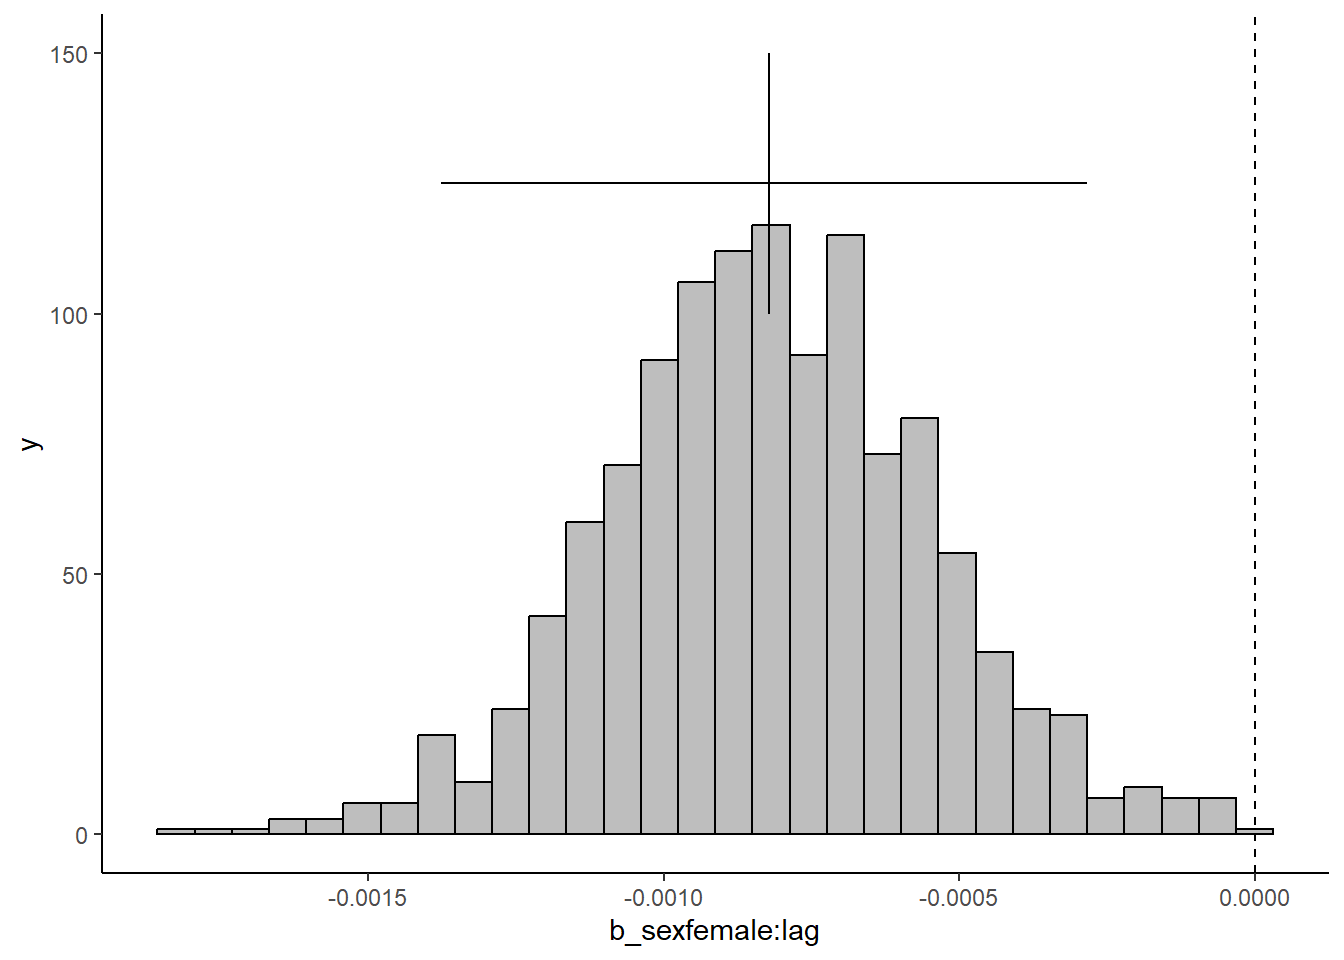

In [ ]:
as.matrix(model_sex, variable = "b_sexfemale:lag") |> 
  ggplot(aes(x = `b_sexfemale:lag`)) +
  geom_histogram(fill = "grey", color = "black", bins = 30) +
    geom_segment(mapping = aes(y = 100, yend = 150, x = pp_mean, xend = pp_mean),
               data = subset(pp_sex, coef == "sexfemale:lag")) +
  geom_segment(mapping = aes(y = 125, yend = 125, x = pp_lower, xend = pp_upper),
                data = subset(pp_sex, coef == "sexfemale:lag")) +
  geom_vline(xintercept = 0, linetype =  "dashed") 


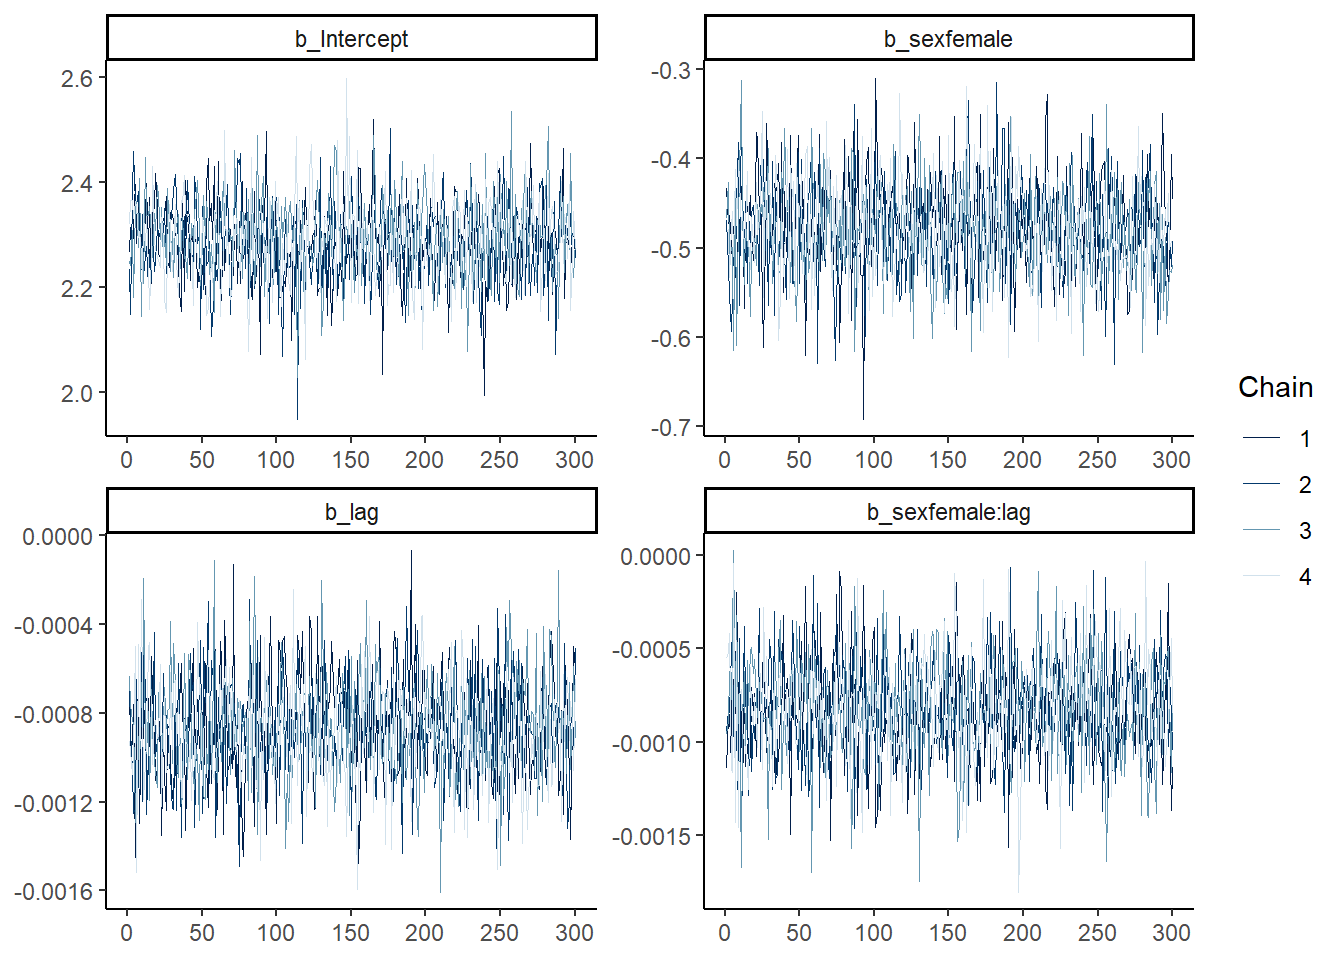

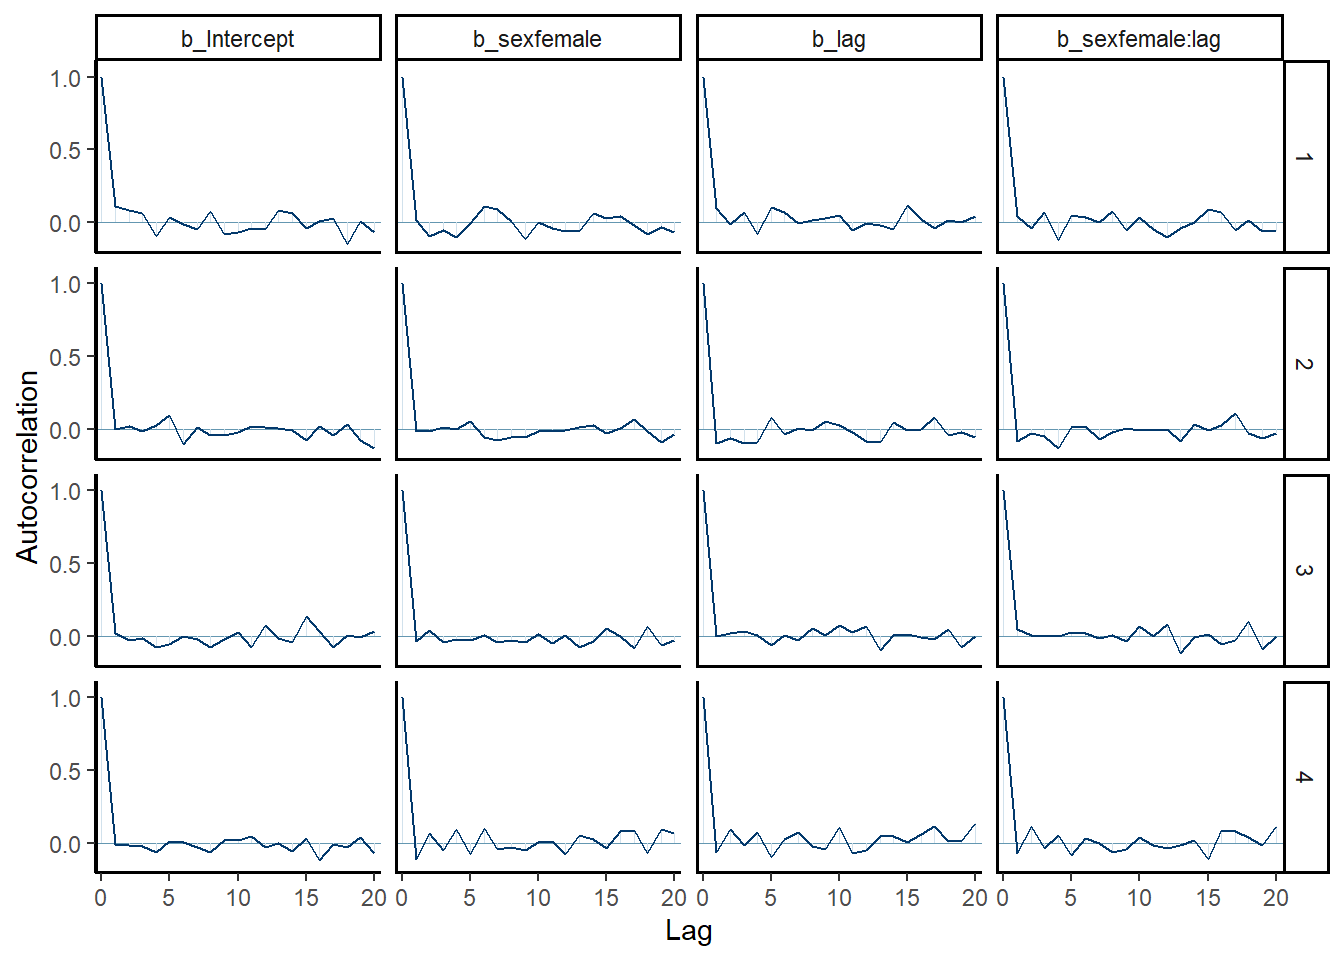

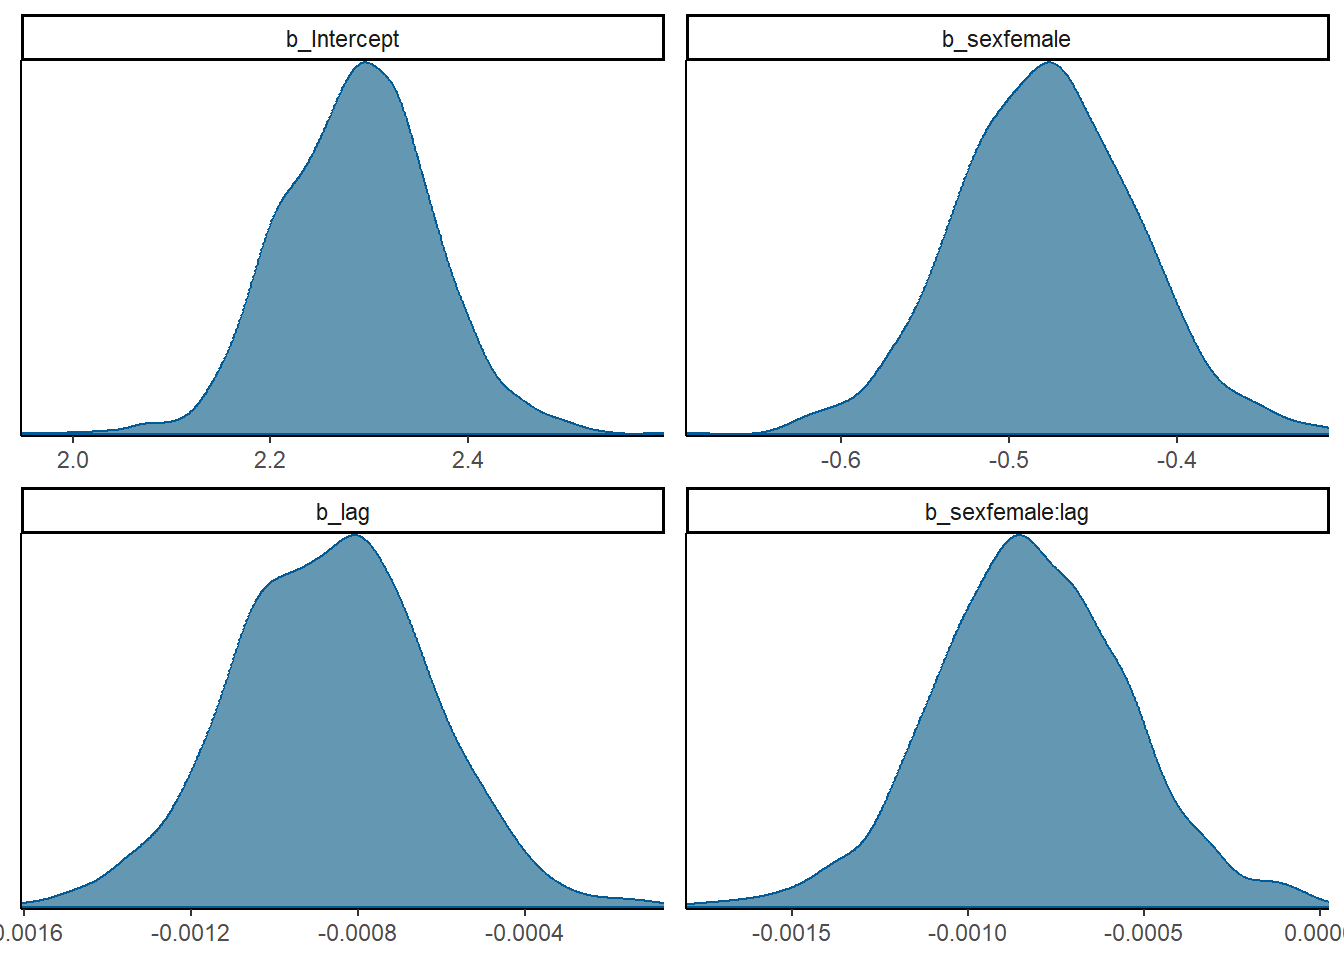

In [ ]:
bayesplot::mcmc_trace(model_sex, pars = c("b_Intercept", "b_sexfemale", "b_lag", "b_sexfemale:lag"))


Check posteriors

Using 10 posterior draws for ppc type 'dens_overlay' by default.

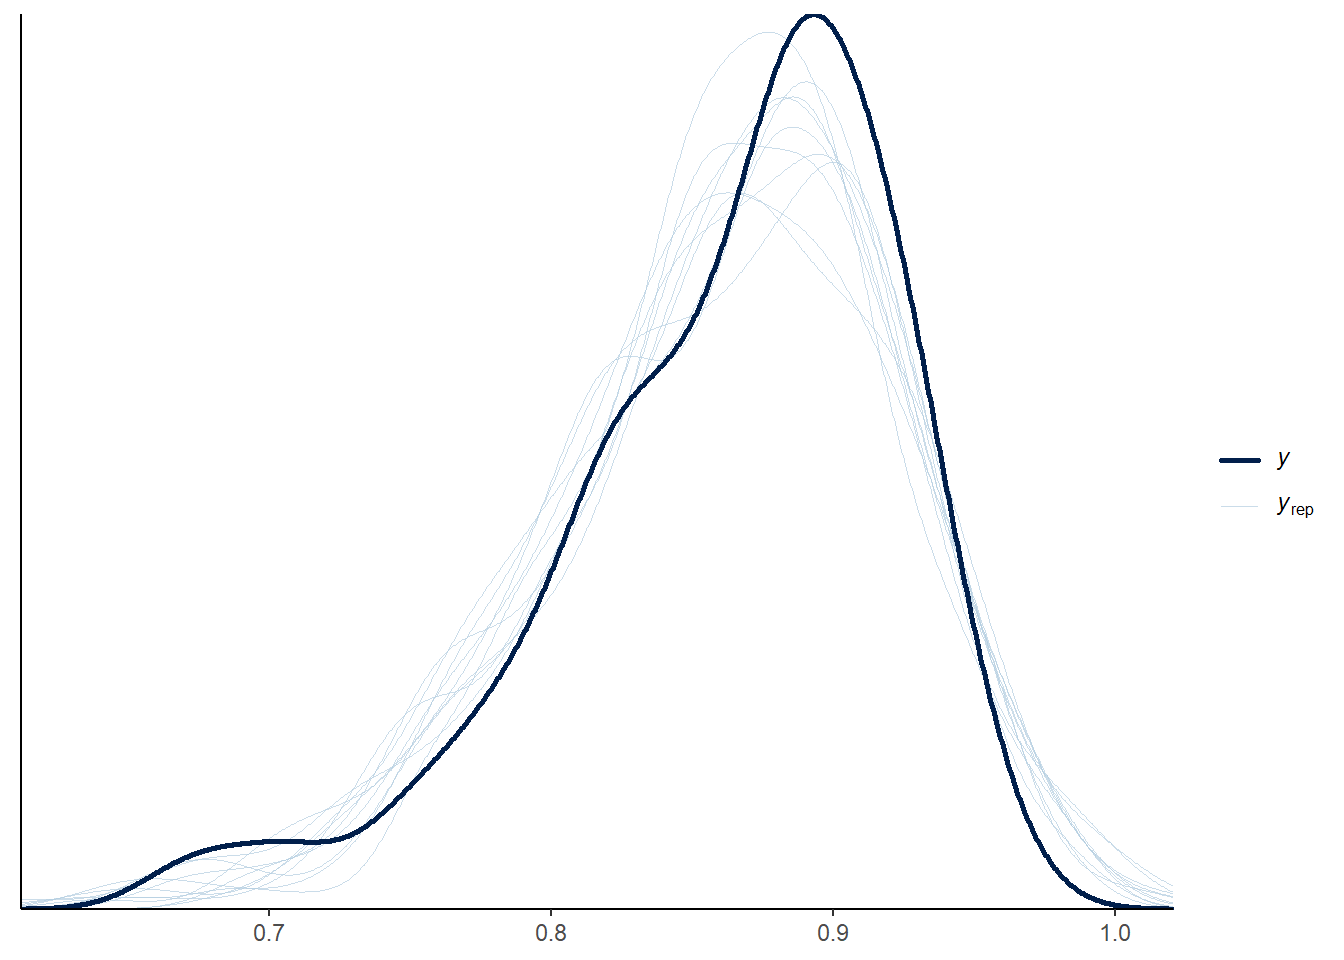

In [ ]:
pp_check(model_sex)


### Income

In [ ]:
data <- auroc_dem_all |> 
  select(id = fold_num, id2 = repeat_num, `above poverty`, `below poverty`, lag) |> 
  pivot_longer(cols = c(`above poverty`, `below poverty`), names_to = "income", 
               values_to = "auroc") |>
  mutate(income = factor(income)) |>
  glimpse()


Rows: 300
Columns: 5
$ id     <dbl> 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 1, …
$ id2    <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, …
$ lag    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ income <fct> above poverty, below poverty, above poverty, below poverty, abo…
$ auroc  <dbl> 0.8891591, NA, 0.9193512, 0.9155717, 0.8950993, 0.3825632, 0.90…

Compiling Stan program...

Start sampling


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 6000 [  0%]  (Warmup)
Chain 1: Iteration:  600 / 6000 [ 10%]  (Warmup)
Chain 1: Iteration: 1200 / 6000 [ 20%]  (Warmup)
Chain 1: Iteration: 1800 / 6000 [ 30%]  (Warmup)
Chain 1: Iteration: 2400 / 6000 [ 40%]  (Warmup)
Chain 1: Iteration: 3000 / 6000 [ 50%]  (Warmup)
Chain 1: Iteration: 3001 / 6000 [ 50%]  (Sampling)
Chain 1: Iteration: 3600 / 6000 [ 60%]  (Sampling)
Chain 1: Iteration: 4200 / 6000 [ 70%]  (Sampling)
Chain 1: Iteration: 4800 / 6000 [ 80%]  (Sampling)
Chain 1: Iteration: 5400 / 6000 [ 90%]  (Sampling)
Chain 1: Iteration: 6000 / 6000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 58.831 seconds (Warm-up)
Chain 1:                54.148 seconds (Sampling)
Chain 1:                11

https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded

In [ ]:
summary(model_income)


 Family: gaussian 
  Links: mu = logit; sigma = identity 
Formula: auroc ~ 1 + income + lag + income * lag + (1 | id2/id) 
   Data: subset(data, !is.na(auroc)) (Number of observations: 286) 
  Draws: 4 chains, each with iter = 6000; warmup = 3000; thin = 10;
         total post-warmup draws = 1200

Multilevel Hyperparameters:
~id2 (Number of levels: 6) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.28      0.24     0.01     0.89 1.00     1017     1248

~id2:id (Number of levels: 30) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.65      0.10     0.49     0.89 1.00     1160     1134

Regression Coefficients:
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                  2.48      0.21     2.09     2.91 1.00     1249
incomebelowpoverty        -1.05      0.10    -1.24    -0.85 1.00     1216
lag                       -0.00      0.00    -0.00    -0.00 1.00   

In [ ]:
pp_income <- summary(model_income)$fixed |>
  as_tibble(rownames = "coef") |> 
  select(coef,
         pp_mean = Estimate, 
         pp_lower = `l-95% CI`, 
         pp_upper = `u-95% CI`) 


plot posterior distribution for income effect

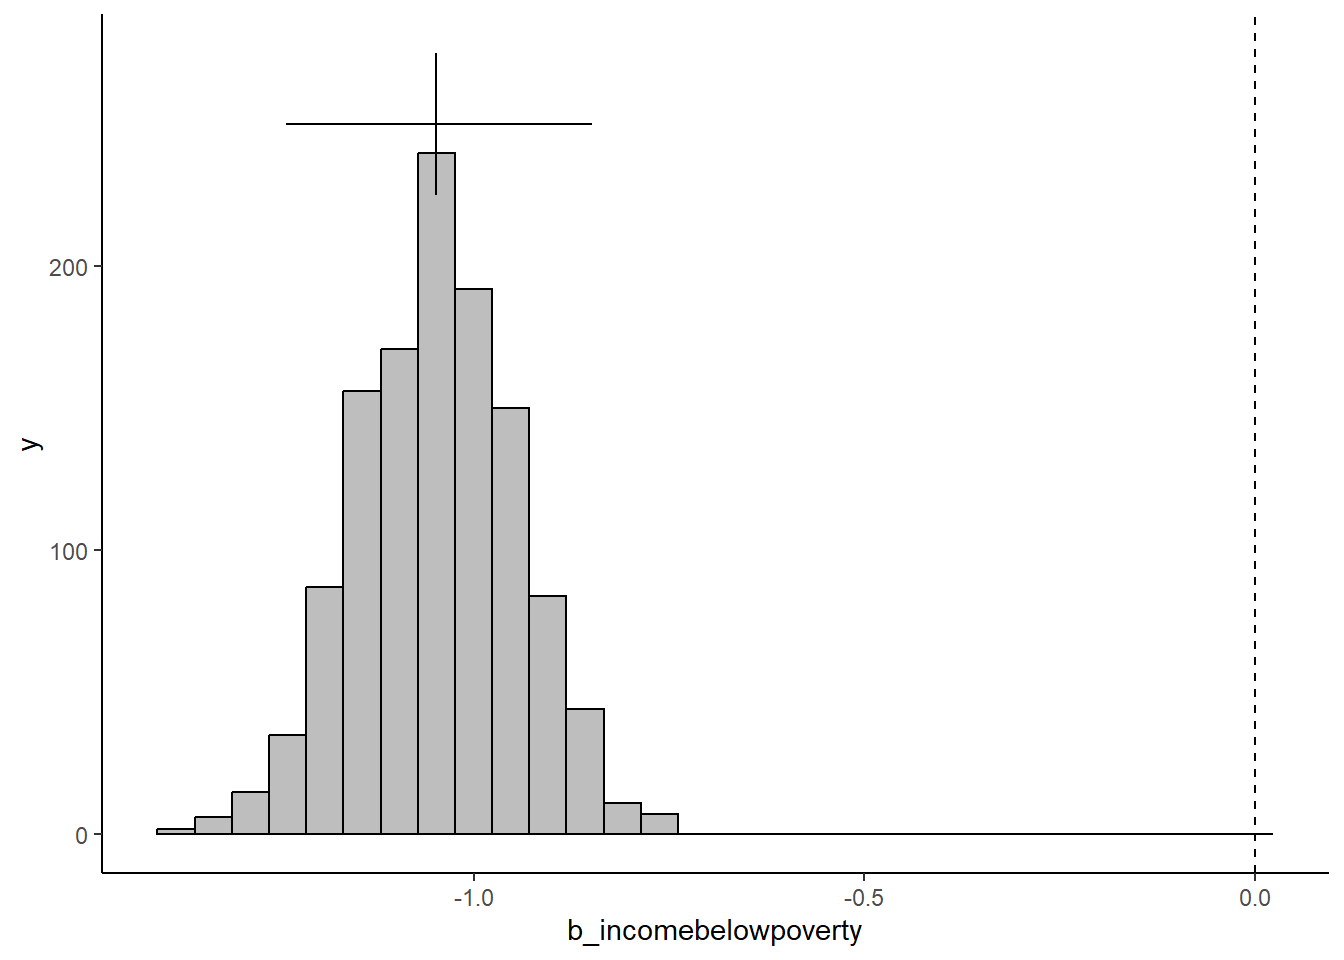

In [ ]:
as.matrix(model_income, variable = "b_incomebelowpoverty") |> 
  as_tibble() |> 
  ggplot(aes(x = b_incomebelowpoverty)) +
  geom_histogram(fill = "grey", color = "black", bins = 30) +
  geom_segment(mapping = aes(y = 225, yend = 275, x = pp_mean, xend = pp_mean),
               data = subset(pp_income, coef == "incomebelowpoverty")) +
  geom_segment(mapping = aes(y = 250, yend = 250, x = pp_lower, xend = pp_upper),
                data = subset(pp_income, coef == "incomebelowpoverty")) +
  geom_vline(xintercept = 0, linetype =  "dashed") 


plot posterior distribution for interaction effect

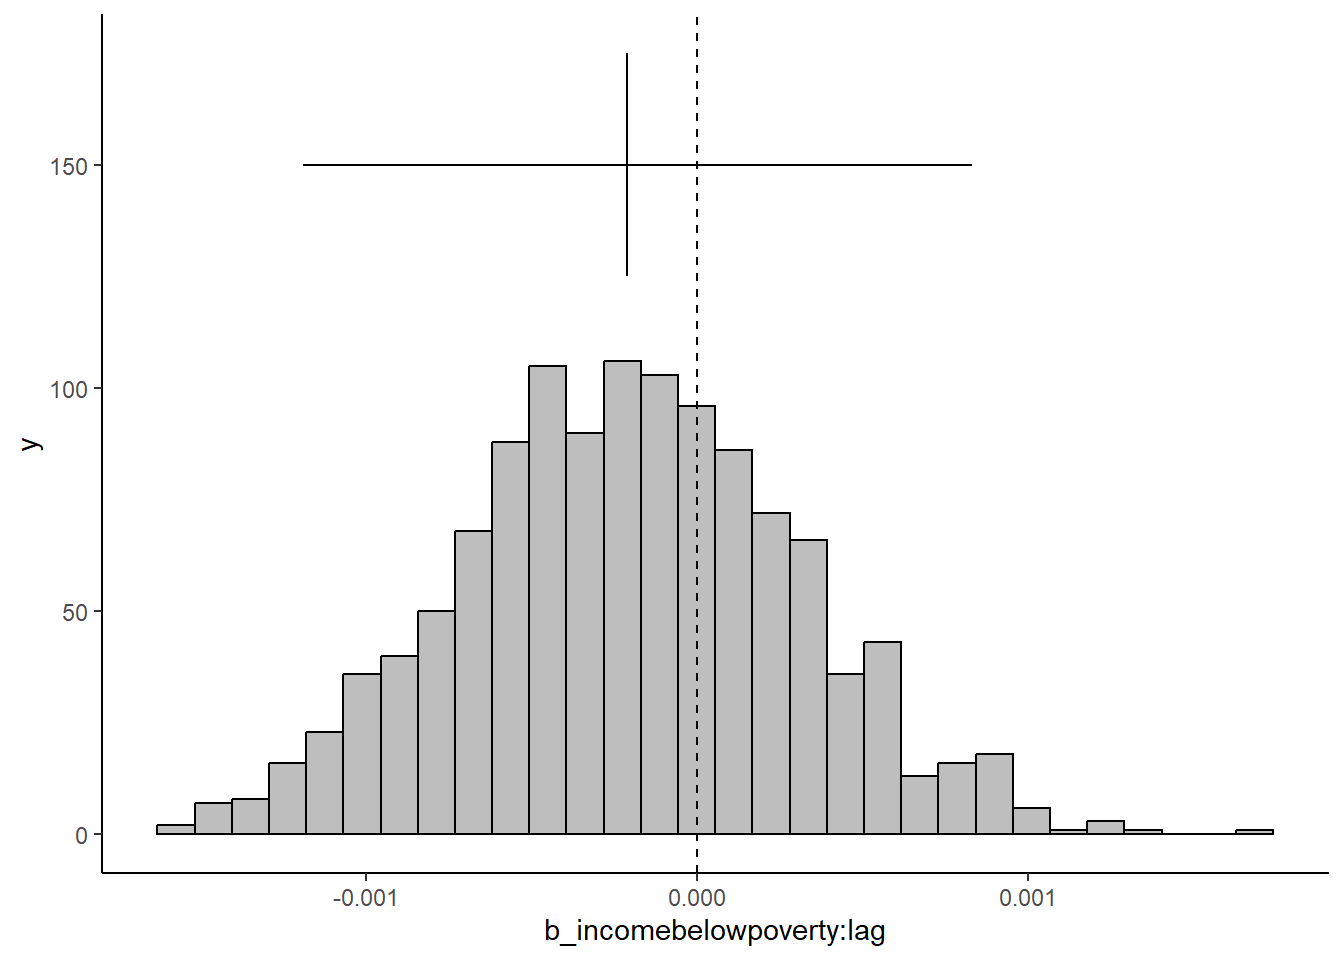

In [ ]:
as.matrix(model_income, variable = "b_incomebelowpoverty:lag") |> 
  ggplot(aes(x = `b_incomebelowpoverty:lag`)) +
  geom_histogram(fill = "grey", color = "black", bins = 30) +
  geom_segment(mapping = aes(y = 125, yend = 175, x = pp_mean, xend = pp_mean),
               data = subset(pp_income, coef == "incomebelowpoverty:lag")) +
  geom_segment(mapping = aes(y = 150, yend = 150, x = pp_lower, xend = pp_upper),
                data = subset(pp_income, coef == "incomebelowpoverty:lag")) +
  geom_vline(xintercept = 0, linetype =  "dashed") 


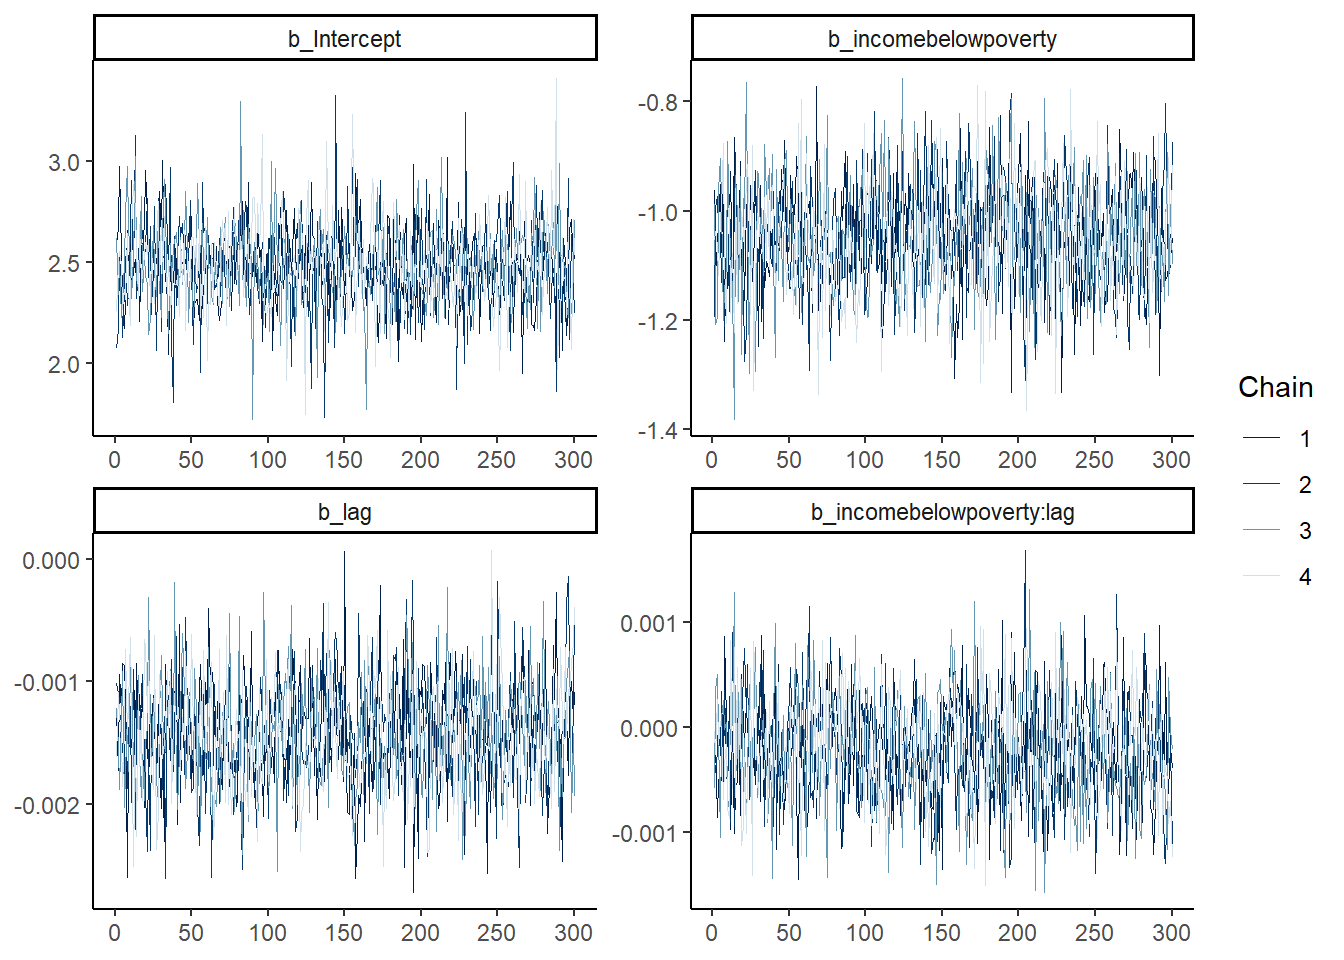

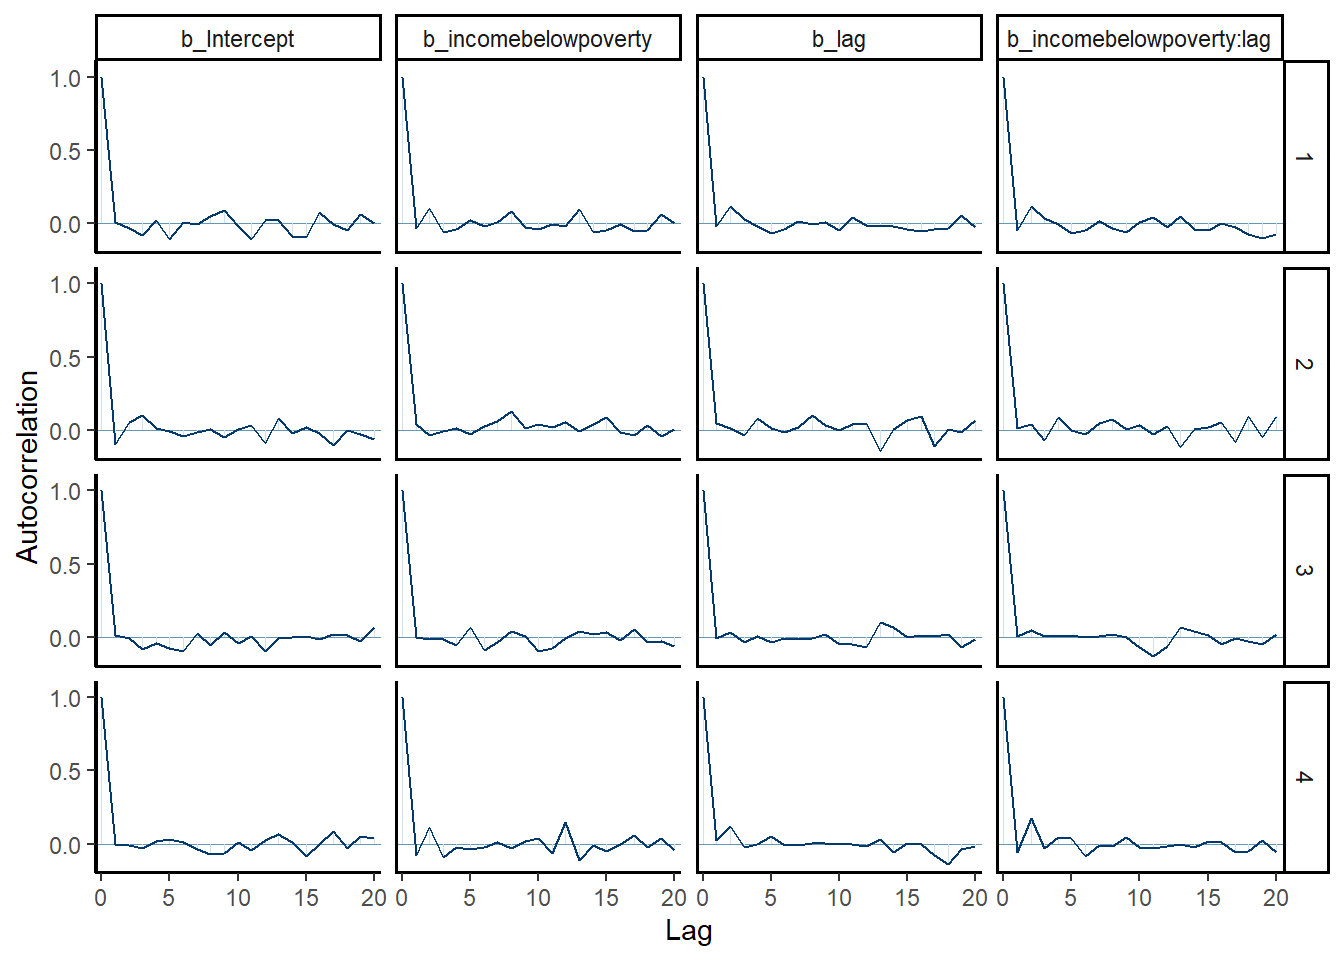

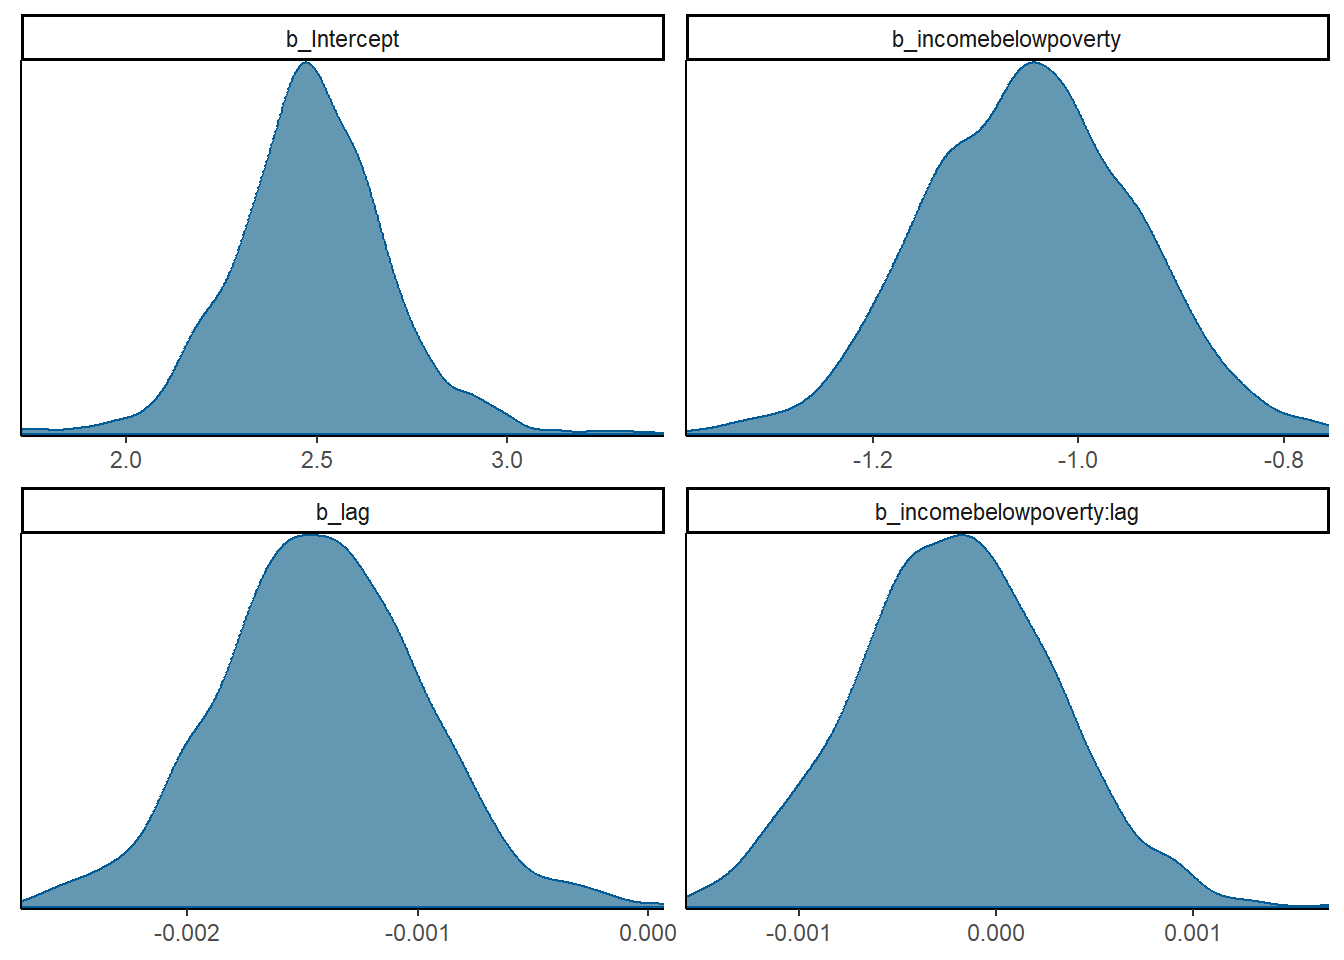

In [ ]:
bayesplot::mcmc_trace(model_income, pars = c("b_Intercept", "b_incomebelowpoverty", "b_lag", "b_incomebelowpoverty:lag"))


Check posteriors

Using 10 posterior draws for ppc type 'dens_overlay' by default.

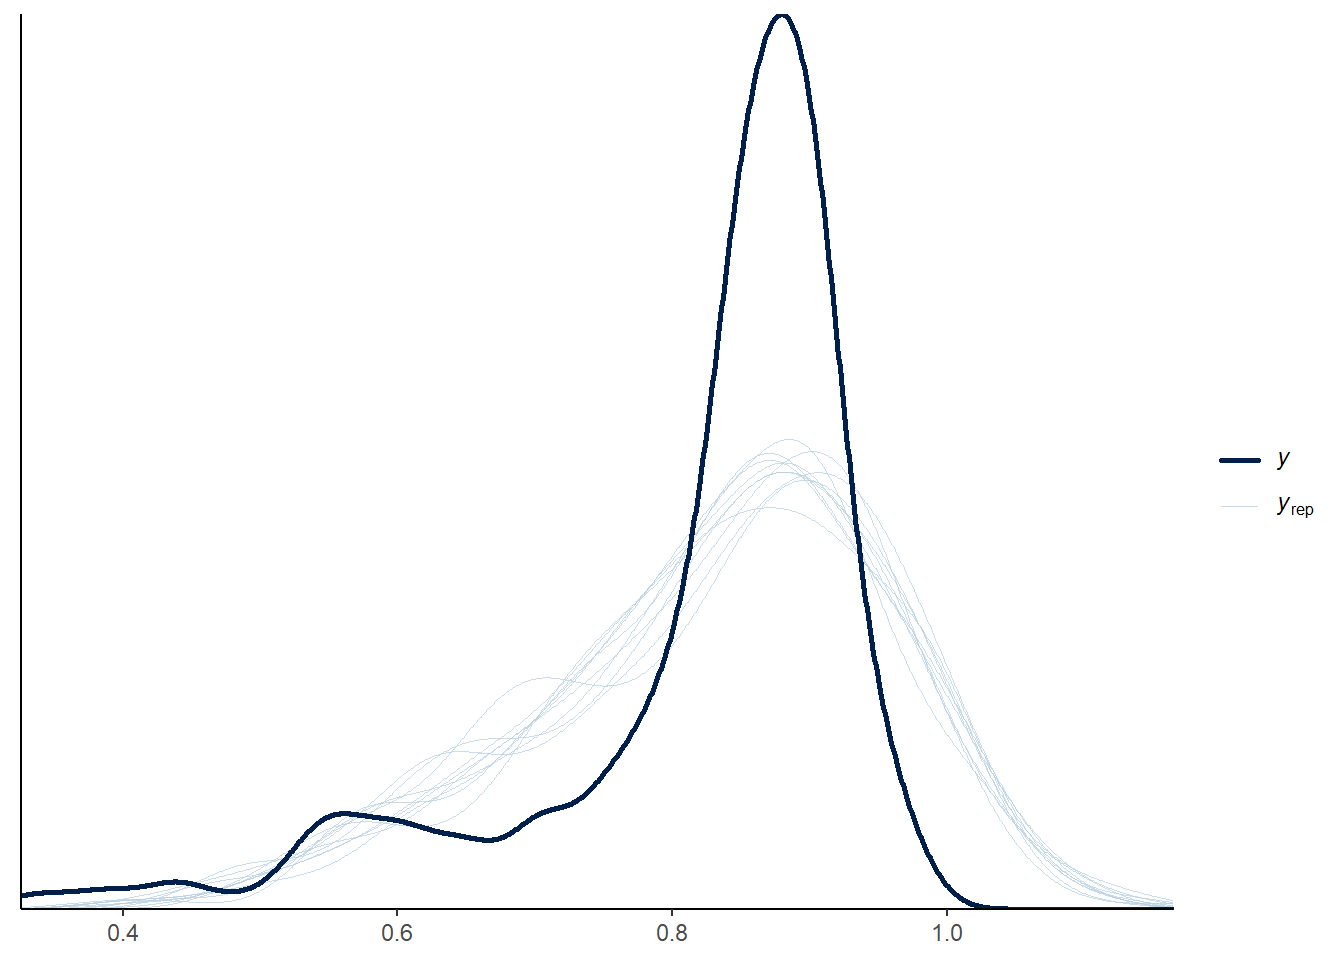

In [ ]:
pp_check(model_income)
